In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.append('../..')

# Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
np.random.seed(42)
datasets = f'../../data/connectomes/'
connectomes = sorted(os.listdir(datasets)) 
print(connectomes)

# Ensure the necessary directories exist
os.makedirs('imgs', exist_ok=True)
os.makedirs('runs', exist_ok=True)


['.DS_Store', 'c.elegans.herm_pharynx_1.graphml', 'c.elegans_neural.male_1.graphml', 'drosophila_medulla_1.graphml', 'kasthuri_graph_v4.graphml', 'mixed.species_brain_1.graphml', 'mouse_brain_1.graphml', 'mouse_retina_1.graphml', 'mouse_visual.cortex_1.graphml', 'mouse_visual.cortex_2.graphml', 'p.pacificus_neural.synaptic_1.graphml', 'p.pacificus_neural.synaptic_2.graphml', 'rattus.norvegicus_brain_1.graphml', 'rattus.norvegicus_brain_2.graphml', 'rattus.norvegicus_brain_3.graphml', 'rhesus_brain_1.graphml', 'rhesus_brain_2.graphml', 'rhesus_cerebral.cortex_1.graphml', 'rhesus_interareal.cortical.network_2.graphml']


In [5]:
def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL'):
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)
   
   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   # TODO: improve the estimation of d
   # d=0

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)
   graphs, spec, spectrum_diffs, best_iteration = graph_model.populate_edges_spectrum(
       warm_up=warm_up,
       max_iterations=n_iteration,
       patience=patience,  # You may want to adjust this value
       real_graph=real_graph
   )

   # Add early stopping condition
   if len(spectrum_diffs) > 10000 and all(abs(spectrum_diffs[-1] - sd) < 1e-6 for sd in spectrum_diffs[-10000:]):
       print("Early stopping: No significant improvement in the last 1000 iterations.")
       best_iteration = len(spectrum_diffs) - 10000

   # Use the best graph found
   best_graph = graphs[best_iteration]
   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type # KL or L1 or L2
   ).calculate_gic()
   
   gic_values = [gic_value]
   return best_graph, sigma, gic_values, spectrum_diffs, best_iteration, graphs

def clean_and_convert(param):
    cleaned_param = ''.join(c for c in param if c.isdigit() or c == '.' or c == '-')
    return float(cleaned_param)

def plot_graphs_in_matrix(sim_graphs_dict, result_dict, global_title, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Use force-directed layout for better distribution of nodes
        pos = nx.spring_layout(G, k=0.5, iterations=50)

        # Normalize node sizes and reduce
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        node_sizes = [((degrees[node] - min_degree) / (max_degree - min_degree + 1e-6)) * 100 + 10 for node in G.nodes()]

        # Normalize node colors
        node_color = list(degrees.values())

        # Draw edges first
        edge_color = 'lightgray'
        alpha = 1
        width = 0.8
        if G.number_of_edges() > 1000:
            # For dense graphs, sample a subset of edges
            edges = list(G.edges())
            sampled_edges = np.random.choice(len(edges), size=1000, replace=False)
            edges = [edges[i] for i in sampled_edges]
            nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_color, alpha=alpha, width=width, ax=ax)
        else:
            nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=alpha, width=width, ax=ax)

        # Draw nodes on top of edges
        scatter = nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=node_sizes, 
                                         cmap=plt.cm.viridis, ax=ax, alpha=0.8)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=10)
        else:
            ax.set_title(f'{name} Graph', fontsize=10)
        ax.axis('off')

        # Add a colorbar to show degree scale
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter, cax=cax)
        cbar.set_label('Node Degree', fontsize=8)
        cbar.ax.tick_params(labelsize=6)

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig

def plot_spectra_in_matrix(sim_graphs_dict, result_dict, global_title, bins=120, save_path=None):
    num_graphs = len(sim_graphs_dict)
    cols = min(4, num_graphs)  # Limit to 4 columns max
    rows = math.ceil(num_graphs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for ax, (name, G) in zip(axes, sim_graphs_dict.items()):
        # Calculate the spectrum (eigenvalues) of the graph
        laplacian = nx.normalized_laplacian_matrix(G)
        eigenvalues = np.linalg.eigvals(laplacian.toarray())
        eigenvalues = np.real(eigenvalues)  # Take only the real part

        # Plot histogram of eigenvalues
        ax.hist(eigenvalues, bins=bins, density=True, alpha=0.7, color='skyblue')

        # Calculate and plot KDE
        kde = stats.gaussian_kde(eigenvalues)
        x_range = np.linspace(min(eigenvalues), max(eigenvalues), 200)
        ax.plot(x_range, kde(x_range), 'r-', lw=2)

        # Set plot details
        if name != 'Real':
            ax.set_title(f'{name} Graph Spectrum\nGIC: {result_dict[name]["GIC"]:.4f}', fontsize=15)
        else:
            ax.set_title(f'{name} Graph Spectrum', fontsize=15)
        ax.set_xlabel('Eigenvalue', fontsize=8)
        ax.set_ylabel('Density', fontsize=8)
        ax.tick_params(axis='both', which='major', labelsize=10)

        # Add text with graph properties
        props = f"Nodes: {G.number_of_nodes()}\nEdges: {G.number_of_edges()}"
        ax.text(0.95, 0.95, props, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # Hide unused axes
    for i in range(len(sim_graphs_dict), len(axes)):
        axes[i].set_visible(False)

    fig.suptitle(global_title, fontsize=20, fontweight='bold')
    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, bbox_inches='tight', dpi=300)

    #plt.show()
    return fig


In [6]:
def analyze_connectome_spectrum(connectome_filename, n_simulations=1, warm_up=1000, n_iteration=100, patience=10, d=0):
    """
    Analyze a single connectome file and save eigenvalues for real and simulated graphs.
    """
    # Read and process the graph
    real_graph = nx.read_graphml(datasets + connectome_filename)
    real_graph = nx.to_numpy_array(real_graph)
    
    # Get the logit graph results for initial parameters
    logit_graph, sigma, _, _, _, _ = get_logit_graph(
        real_graph=nx.from_numpy_array(real_graph),
        d=d,
        warm_up=warm_up,
        n_iteration=n_iteration,
        patience=patience,
        dist_type='KL'
    )
    
    # Setup model selection
    n_runs_graphs = 5
    all_graphs_lg = [nx.from_numpy_array(logit_graph)]
    log_params = [sigma]
    
    selector = ms.GraphModelSelection(
        graph=nx.from_numpy_array(real_graph),
        log_graphs=all_graphs_lg,
        log_params=log_params,
        models=["ER", "WS", "GRG", "BA", "LG"],
        n_runs=n_runs_graphs,
        parameters=[
            {'lo': 0.01, 'hi': 1},  # ER
            {'lo': 0.01, 'hi': 1},  # WS k=8
            {'lo': 1, 'hi': 3},     # GRG
            {'lo': 1, 'hi': 5},     # BA
        ]
    )
    
    result = selector.select_model_avg_spectrum()
    result_dict = {item['model']: {'param': clean_and_convert(item['param'])} 
                  for item in result['estimates']}

    # Get eigenvalues of real graph using adjacency matrix directly
    real_graph_nx = nx.from_numpy_array(real_graph)
    real_eigenvalues = np.real(np.linalg.eigvals(real_graph))  # Use adjacency matrix
    
    # Save real eigenvalues
    real_data = {'eigenvalues': real_eigenvalues}
    
    # Generate multiple graphs for each model and save eigenvalues
    simulated_eigenvalues = {}
    
    for model in result_dict.keys():
        simulated_eigenvalues[model] = []
        
        for i in range(n_simulations):
            if model != 'LG':
                # Generate graph using appropriate model
                func = selector.model_function(model_name=model)
                G = func(real_graph.shape[0], float(result_dict[model]['param']))
                adj_matrix = nx.to_numpy_array(G)
            else:
                # Generate new logit graph for each simulation
                logit_graph, _, _, _, _, _ = get_logit_graph(
                    real_graph=nx.from_numpy_array(real_graph),
                    d=d,
                    warm_up=warm_up,
                    n_iteration=n_iteration,
                    patience=patience,
                    dist_type='KL'
                )
                #G = nx.from_numpy_array(logit_graph)
                adj_matrix = logit_graph
            
            # Calculate eigenvalues using adjacency matrix
            eigenvalues = np.real(np.linalg.eigvals(adj_matrix))  # Use adjacency matrix
            simulated_eigenvalues[model].append(eigenvalues)
        
    # Save results
    os.makedirs(f'runs/connectomes_spectra_kde/{connectome_filename}', exist_ok=True)
    with open(f'runs/connectomes_spectra_kde/{connectome_filename}/simulated_eigenvalues.pkl', 'wb') as f:
        pickle.dump(simulated_eigenvalues, f)
    with open(f'runs/connectomes_spectra_kde/{connectome_filename}/real_eigenvalues.pkl', 'wb') as f:
        pickle.dump(real_data, f)
    
    return real_data, simulated_eigenvalues

# simulation

In [22]:
# Good connectomes Previously fitted and had nice results
good_connectomes = [
    'c.elegans_neural.male_1.graphml',
    'mouse_brain_1.graphml',
    'mouse_visual.cortex_2.graphml',
    'p.pacificus_neural.synaptic_2.graphml',
    'rhesus_brain_2.graphml'
]
for connectome_file in good_connectomes:
    real_graph = nx.read_graphml(datasets + connectome_file)
    real_graph = nx.to_numpy_array(real_graph)
    print(f'Nodes: {real_graph.shape[0]} | {connectome_file}')

#connectome_file = 'rhesus_brain_2.graphml'
#connectome_file = 'p.pacificus_neural.synaptic_2.graphml'
#connectome_file = 'mouse_visual.cortex_2.graphml'
#connectome_file = 'mouse_brain_1.graphml'
connectome_file = 'c.elegans_neural.male_1.graphml'



Nodes: 272 | c.elegans_neural.male_1.graphml
Nodes: 213 | mouse_brain_1.graphml
Nodes: 195 | mouse_visual.cortex_2.graphml
Nodes: 50 | p.pacificus_neural.synaptic_2.graphml
Nodes: 91 | rhesus_brain_2.graphml


In [8]:
# ----- Simulation Section -----
warm_up = 7000
n_iteration = 7000
patience = 10
n_simulations = 10  # For estimation the confidence intervals
simulation_results = []
n_connectomes = 1 # dummy
d = 0 

In [9]:
real_graph = nx.read_graphml(datasets + connectome_file)
logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, all_graphs = get_logit_graph(
    real_graph=real_graph,
    d=d,
    warm_up=warm_up,
    n_iteration=n_iteration,
    patience=patience,
    dist_type='KL'
)
sim_graphs_dict = {
    'Real': real_graph,
    'Logit': nx.from_numpy_array(logit_graph)
}
result_dict = {
    'Real': {'GIC': 0},
    'Logit': {'GIC': gic_values[0]}
}

iteration: 0
	 Spectrum difference: 228.42901286637255
iteration: 1000
	 Spectrum difference: 175.5256151557875
iteration: 2000
	 Spectrum difference: 187.80977552631563
iteration: 3000
	 Spectrum difference: 255.33117887045873
iteration: 4000
	 Spectrum difference: 342.5832248480023
iteration: 5000
	 Spectrum difference: 434.2392276331808
iteration: 6000
	 Spectrum difference: 526.9894472345471
	 Best iteration: 1270
	 Best spectrum difference: 169.83068363040442
	 Number of edges: 15818.0, Number of edges real graph: 4451.0


In [11]:
os.makedirs('imgs/imgs_connectomes_spectra_kde', exist_ok=True)

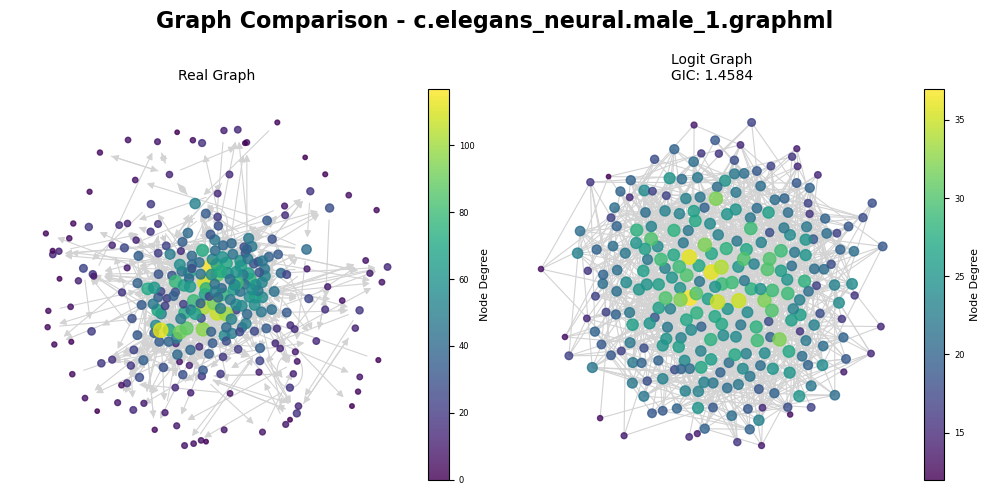

Edge counts - Real: 4451, Logit: 3032


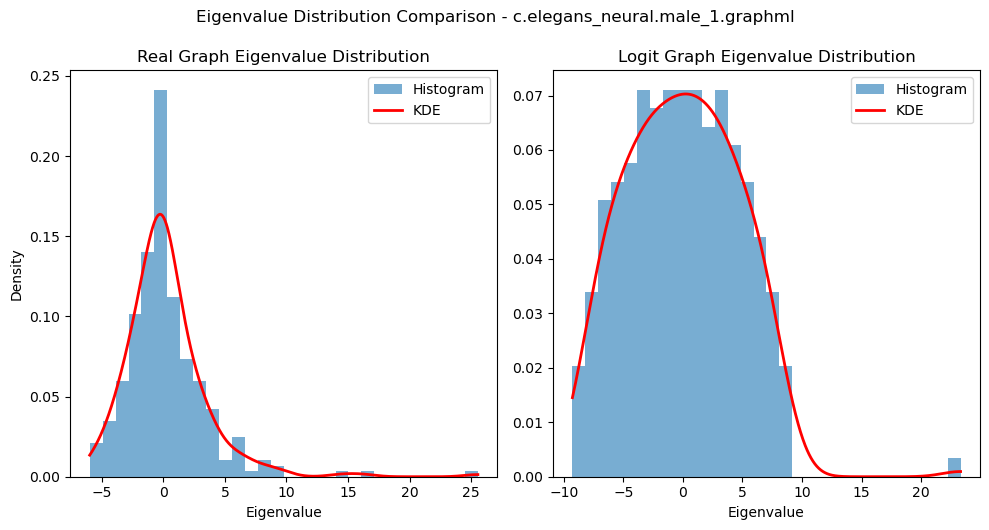

In [12]:
# Single connectome viz
fig = plot_graphs_in_matrix(
    sim_graphs_dict, 
    result_dict, 
    global_title=f'Graph Comparison - {connectome_file}',
    save_path=f'imgs/imgs_connectomes_spectra_kde/graph_comparison_{connectome_file}.png'
)
plt.show()

# Get edge counts
real_edges = real_graph.number_of_edges()
logit_edges = nx.from_numpy_array(logit_graph).number_of_edges()
print(f"Edge counts - Real: {real_edges}, Logit: {logit_edges}")

# Compare eigenvalue distributions with KDE
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Get eigenvalues for both graphs
real_adj = nx.to_numpy_array(real_graph)
real_eigenvalues = np.linalg.eigvals(real_adj).real
real_eigenvalues = real_eigenvalues + np.random.normal(0, 1e-10, size=real_eigenvalues.shape)
logit_eigenvalues = np.linalg.eigvals(logit_graph).real
logit_eigenvalues = logit_eigenvalues + np.random.normal(0, 1e-10, size=logit_eigenvalues.shape)

# Plot for Real graph
axes[0].hist(real_eigenvalues, bins=30, alpha=0.6, density=True, label='Histogram')
real_kde = gaussian_kde(real_eigenvalues)
x_range = np.linspace(min(real_eigenvalues), max(real_eigenvalues), 1000)
axes[0].plot(x_range, real_kde(x_range), 'r-', linewidth=2, label='KDE')
axes[0].set_title('Real Graph Eigenvalue Distribution')
axes[0].set_xlabel('Eigenvalue')
axes[0].set_ylabel('Density')
axes[0].legend()

# Plot for Logit graph
axes[1].hist(logit_eigenvalues, bins=30, alpha=0.6, density=True, label='Histogram')
logit_kde = gaussian_kde(logit_eigenvalues)
x_range = np.linspace(min(logit_eigenvalues), max(logit_eigenvalues), 1000)
axes[1].plot(x_range, logit_kde(x_range), 'r-', linewidth=2, label='KDE')
axes[1].set_title('Logit Graph Eigenvalue Distribution')
axes[1].set_xlabel('Eigenvalue')
axes[1].legend()

plt.tight_layout()
plt.suptitle(f'Eigenvalue Distribution Comparison - {connectome_file}', y=1.05)
# plt.savefig(f'../images/imgs_connectomes_spectra_kde/eigenvalue_kde_{connectome_file}.png', bbox_inches='tight')
plt.show()

In [13]:
def find_optimal_d(real_graph, d_values, warm_up=1000, n_iteration=1000, patience=50, dist_type='KL'):
    best_gic = float('inf')
    optimal_d = None
    results_dict = {}
    
    print("Starting d optimization...")
    for d in d_values:
        print(f"\nTesting d = {d}")
        try:
            # Get logit graph and GIC for current d
            logit_graph, sigma, gic_values, spectrum_diffs, best_iteration, _ = get_logit_graph(
                real_graph=real_graph,
                d=d,
                warm_up=warm_up,
                n_iteration=n_iteration,
                patience=patience,
                dist_type=dist_type
            )
            
            current_gic = gic_values[0]
            
            results_dict[d] = {
                'gic': current_gic,
                'sigma': sigma,
                'best_iteration': best_iteration,
                'logit_graph': logit_graph
            }
            print(f"d = {d}: GIC = {current_gic:.4f}")
            
            # Update best if current is better
            if current_gic < best_gic:
                best_gic = current_gic
                optimal_d = d
                print(f"New best d found: {d} (GIC: {current_gic:.4f})")
                
        except Exception as e:
            print(f"Error occurred for d = {d}: {str(e)}")
            results_dict[d] = {
                'error': str(e)
            }
            continue
    
    print("\nOptimization complete!")
    print(f"Optimal d: {optimal_d}")
    print(f"Best GIC: {best_gic:.4f}")
    
    return optimal_d, best_gic, results_dict

In [14]:
d_values = [0, 1, 2, 3, 4]
optimal_d, best_gic, results = find_optimal_d(
    real_graph=real_graph,
    d_values=d_values,
    warm_up=7000,
    n_iteration=7000,
    patience=10
)

Starting d optimization...

Testing d = 0
iteration: 0
	 Spectrum difference: 227.89345480069287
iteration: 1000
	 Spectrum difference: 176.67752986067794
iteration: 2000
	 Spectrum difference: 194.49689996895344
iteration: 3000
	 Spectrum difference: 261.5203023993536
iteration: 4000
	 Spectrum difference: 346.64394810010754
iteration: 5000
	 Spectrum difference: 438.56403311292416
iteration: 6000
	 Spectrum difference: 531.1706319811905
	 Best iteration: 1217
	 Best spectrum difference: 174.95341858029548
	 Number of edges: 15866.0, Number of edges real graph: 4451.0
d = 0: GIC = 1.4559
New best d found: 0 (GIC: 1.4559)

Testing d = 1
iteration: 0
	 Spectrum difference: 235.0718851174515
iteration: 1000
	 Spectrum difference: 180.61893056640855
iteration: 2000
	 Spectrum difference: 191.30509729935835
iteration: 3000
	 Spectrum difference: 257.32562746997377
iteration: 4000
	 Spectrum difference: 340.86159990890826
iteration: 5000
	 Spectrum difference: 434.6766942454456
iteration: 6

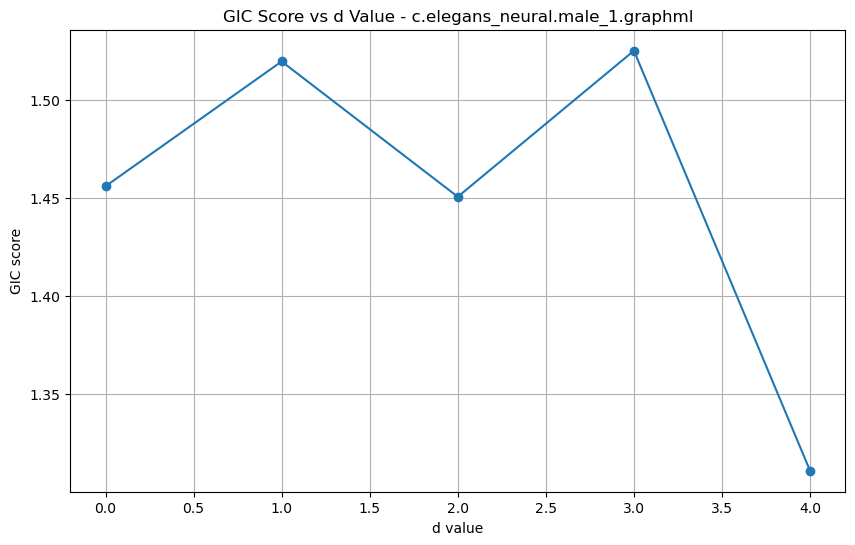

In [15]:
# Plot GIC vs d
plt.figure(figsize=(10, 6))
d_vals = []
gic_vals = []
for d, result in results.items():
    if 'gic' in result:  # Only plot if no error occurred
        d_vals.append(d)
        gic_vals.append(result['gic'])

plt.plot(d_vals, gic_vals, 'o-')
plt.xlabel('d value')
plt.ylabel('GIC score')
plt.title(f'GIC Score vs d Value - {connectome_file}')
plt.grid(True)
plt.show()

In [16]:
d = optimal_d
print(f'Optimal d: {d}')

Optimal d: 4


# Full simulation

In [17]:
real_data_eigen, simulated_eigenvalues = analyze_connectome_spectrum(connectome_file, 
                                                                     n_simulations=n_simulations, 
                                                                     warm_up=warm_up, 
                                                                     n_iteration=n_iteration, 
                                                                     patience=patience, d=d)

iteration: 0
	 Spectrum difference: 231.19268002316196
iteration: 1000
	 Spectrum difference: 175.13682235580873
iteration: 2000
	 Spectrum difference: 187.85056872559
iteration: 3000
	 Spectrum difference: 253.69036201885024
iteration: 4000
	 Spectrum difference: 339.8128129792421
iteration: 5000
	 Spectrum difference: 432.4134988932125
iteration: 6000
	 Spectrum difference: 527.2340333134401
	 Best iteration: 1284
	 Best spectrum difference: 172.47411535228696
	 Number of edges: 15832.0, Number of edges real graph: 5867.0
Testing the selected model for ER
ER gic: 1.4223951825732781
Testing the selected model for WS
WS gic: 0.22163212432476664
Testing the selected model for GRG
GRG gic: 7.314395625888951
Testing the selected model for BA
BA gic: 0.5832178616136378
Testing the selected model for LG
LG gic: 1.4546860987452033
iteration: 0
	 Spectrum difference: 235.12021156197576
iteration: 1000
	 Spectrum difference: 180.84545710565618
iteration: 2000
	 Spectrum difference: 188.9571809

In [18]:
# TODO: Load the result from the folder
def plot_spectrum_comparison(real_data, simulated_eigenvalues, title, save_path=None, figsize=(15, 10), xlim=None, ylim=None, log_scale=False):
    """
    Plot KDE comparison of eigenvalue spectra with confidence intervals.
    
    Args:
        real_data (dict): Contains eigenvalues for real graph
        simulated_eigenvalues (dict): Contains eigenvalues for each model
        title (str): Plot title
        save_path (str): Path to save the figure
        figsize (tuple): Figure size (width, height)
        xlim (tuple): Optional x-axis limits as (min, max)
        ylim (tuple): Optional y-axis limits as (min, max)
        log_scale (bool): Whether to use log scale for y-axis
    """
    # Color scheme for different models
    colors = {
        'Real': '#1f77b4',    # Blue
        'LG': '#2ca02c',      # Green
        'ER': '#ff7f0e',      # Orange
        'BA': '#d62728',      # Red
        'WS': '#9467bd',      # Purple
        'GRG': '#8c564b'      # Brown
    }
    
    plt.figure(figsize=figsize)
    
    # Get real eigenvalues
    real_eigenvalues = real_data['eigenvalues']
    
    # Determine common x-range
    all_eigenvalues = [real_eigenvalues]
    for model_eigs in simulated_eigenvalues.values():
        all_eigenvalues.extend([eig for eig in model_eigs])
    
    if xlim is None:
        x_min = min([np.min(eig) for eig in all_eigenvalues])
        x_max = max([np.max(eig) for eig in all_eigenvalues])
    else:
        x_min, x_max = xlim
    x_range = np.linspace(x_min, x_max, 200)
    
    # Plot real data with small noise to avoid singular matrix
    real_eigenvalues_noisy = real_eigenvalues + np.random.normal(0, 1e-10, size=real_eigenvalues.shape)
    real_kde = gaussian_kde(real_eigenvalues_noisy)
    plt.plot(x_range, real_kde(x_range), 
            label='Real', 
            color=colors['Real'],
            linewidth=2)
    
    # Plot simulated data with confidence intervals
    for model, eigenvalues_list in simulated_eigenvalues.items():
        kde_curves = []
        
        # Calculate KDE for each simulation
        for eigenvalues in eigenvalues_list:
            # Add small noise to avoid singular matrix
            eigenvalues_noisy = eigenvalues + np.random.normal(0, 1e-10, size=eigenvalues.shape)
            kde = gaussian_kde(eigenvalues_noisy)
            kde_curves.append(kde(x_range))
        
        # Convert to numpy array for calculations
        kde_curves = np.array(kde_curves)
        
        # Calculate mean and confidence intervals
        mean_curve = np.mean(kde_curves, axis=0)
        
        # Use tighter confidence intervals for LG model (80% instead of 95%)
        lower_ci = np.percentile(kde_curves, 5, axis=0)
        upper_ci = np.percentile(kde_curves, 95, axis=0)
        
        # Plot mean curve
        plt.plot(x_range, mean_curve, 
                label=model, 
                color=colors.get(model, 'gray'),
                linewidth=2)
        
        # Plot confidence interval
        plt.fill_between(x_range, 
                        lower_ci, 
                        upper_ci,
                        alpha=0.2, 
                        color=colors.get(model, 'gray'))
    
    plt.title(f'Spectrum Analysis: {title}')
    plt.xlabel('Eigenvalue')
    plt.ylabel('Density')
    if log_scale:
        plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Set x-axis limits if provided
    if xlim is not None:
        plt.xlim(xlim)
        
    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(ylim)
    
    # Add statistics
    stats_text = "Statistics:\n"
    stats_text += f"Real mean: {np.mean(real_eigenvalues):.3f}\n"
    stats_text += f"Real std: {np.std(real_eigenvalues):.3f}\n"
    
    for model, eigenvalues_list in simulated_eigenvalues.items():
        all_eigs = np.concatenate(eigenvalues_list)
        stats_text += f"\n{model} mean: {np.mean(all_eigs):.3f}\n"
        stats_text += f"{model} std: {np.std(all_eigs):.3f}"
    
    plt.text(0.02, 0.98, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=8)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


In [21]:
connectome_file

'mouse_visual.cortex_2.graphml'

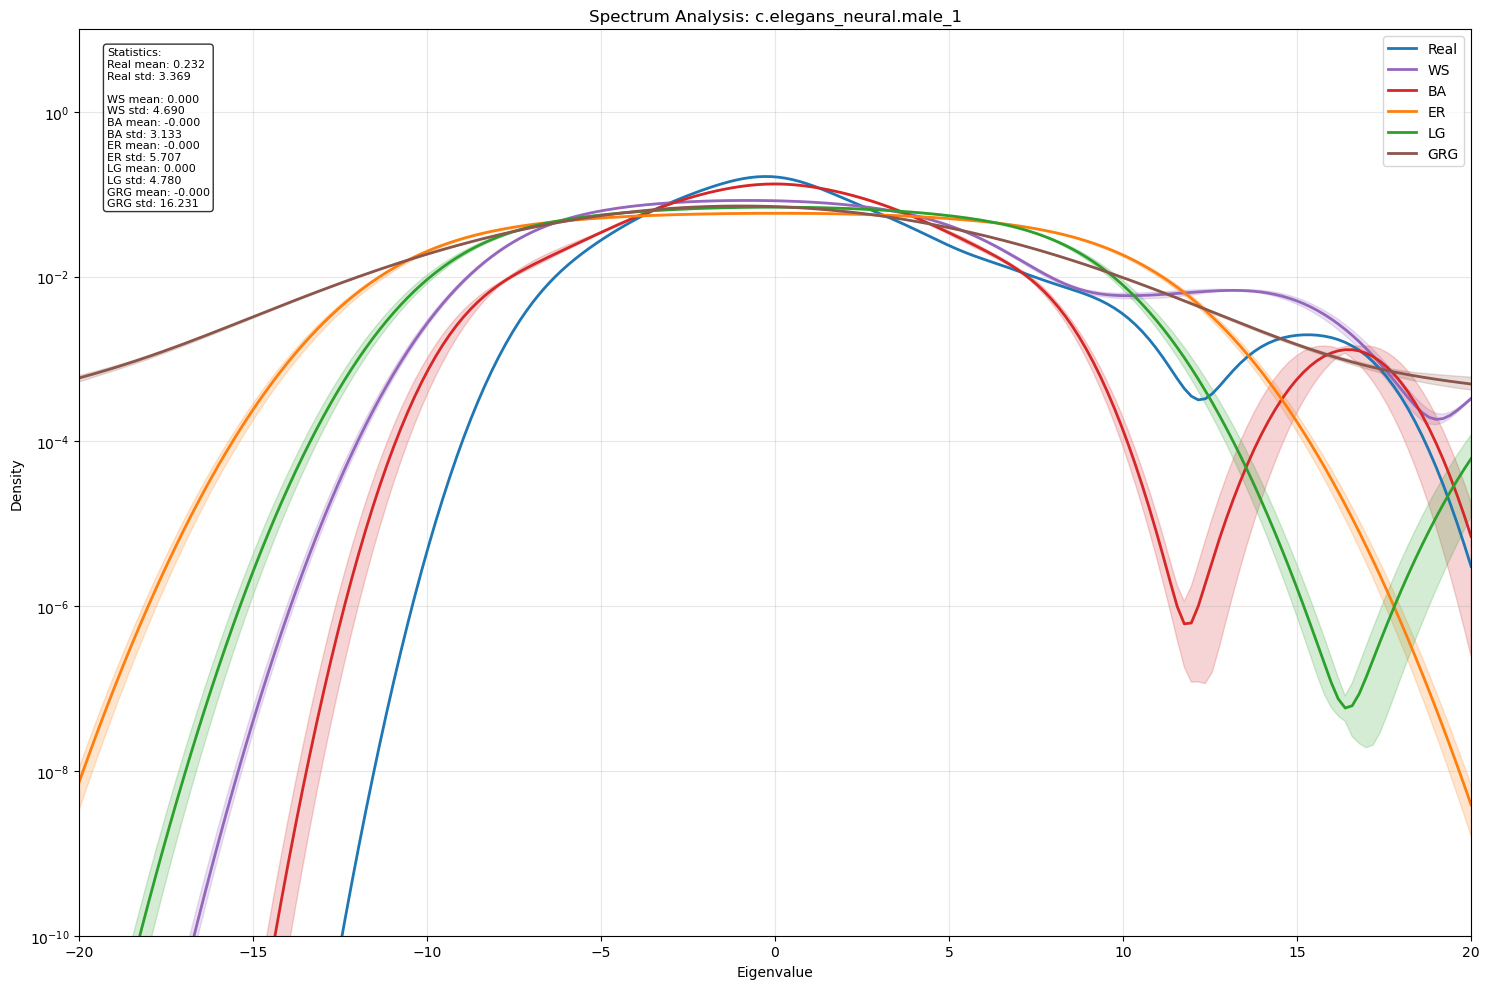

In [23]:
# Load the real_data_eigen and simulated_eigenvalues
real_data_eigen = pickle.load(open(f'runs/connectomes_spectra_kde/{connectome_file}/real_eigenvalues.pkl', 'rb'))
simulated_eigenvalues = pickle.load(open(f'runs/connectomes_spectra_kde/{connectome_file}/simulated_eigenvalues.pkl', 'rb'))

# Create the plot
plot_spectrum_comparison(
    real_data_eigen,
    simulated_eigenvalues,
    title=connectome_file.replace('.graphml', ''),
    save_path=f'imgs/imgs_connectomes_spectra_kde/spectrum_comparison_{connectome_file}.png',
    xlim=(-20, 20), 
    ylim=(1e-10, 1e1),
    log_scale=True
)

In [24]:
123

123

# Full plots

['imgs/imgs_connectomes_spectra_kde/spectrum_comparison_c.elegans_neural.male_1.graphml.png', 'imgs/imgs_connectomes_spectra_kde/spectrum_comparison_mouse_brain_1.graphml.png', 'imgs/imgs_connectomes_spectra_kde/spectrum_comparison_mouse_visual.cortex_2.graphml.png', 'imgs/imgs_connectomes_spectra_kde/spectrum_comparison_p.pacificus_neural.synaptic_2.graphml.png', 'imgs/imgs_connectomes_spectra_kde/spectrum_comparison_rhesus_brain_2.graphml.png']


FileNotFoundError: [Errno 2] No such file or directory: 'imgs/imgs_connectomes_spectra_kde/spectrum_comparison_mouse_brain_1.graphml.png'

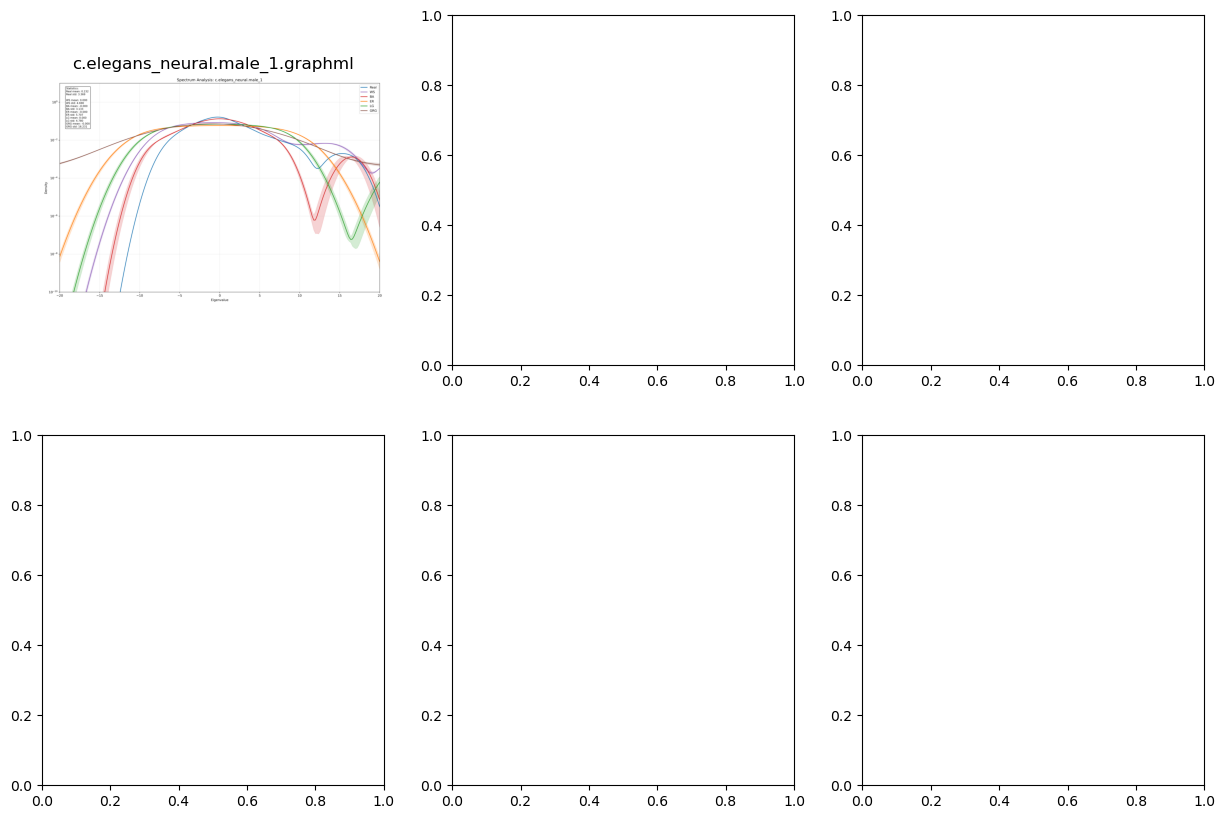

In [25]:
import glob
import matplotlib.pyplot as plt
from PIL import Image

# Get all spectrum comparison images
image_files = [f'imgs/imgs_connectomes_spectra_kde/spectrum_comparison_{connectome}.png' 
               for connectome in good_connectomes]

print(image_files)

# Calculate grid dimensions
n_images = len(image_files)
n_cols = 3  # We can adjust this to change layout
n_rows = (n_images + n_cols - 1) // n_cols  # Ceiling division to get required rows

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Load and display each image
for idx, img_path in enumerate(sorted(image_files)):
    # Load image
    img = Image.open(img_path)
    
    # Display image
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    # Extract filename for title
    title = img_path.split('spectrum_comparison_')[-1].replace('.png','')
    axes[idx].set_title(title)

# Remove empty subplots if any
for idx in range(len(image_files), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
fig.savefig(f'imgs/imgs_connectomes_spectra_kde/spectrum_comparison.png', bbox_inches='tight', dpi=300)
plt.show()